In [100]:
import json
import math
import pickle

from utils import read_lines

In [101]:
PATH = json.load(open('../path_config.json'))

#### Read XSum

In [102]:
document_path = PATH['xsum_fariseq'] + '/test.source'
target_path = PATH['xsum_fariseq'] + '/test.target'
xsum_source = read_lines(document_path)
xsum_target = read_lines(target_path)
print(len(xsum_source))
assert len(xsum_source) == len(xsum_target)

11301


#### Evaluate Annotated Dataset

In [103]:
from tqdm import tqdm

In [104]:
data = json.load(open('../data/annotated_with_probability_200.json', 'r'))
print(len(data))

200


In [105]:
data[55]

{'id': 10943,
 'pred': "A powerful cyclone has killed at least 11 people and injured more than 100 in Vanuatu, the Pacific nation's president has said.",
 'ents': [{'start': 30,
   'end': 41,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'at least 11',
   'bart.large': 0.0215301513671875,
   'xsum_cmlm_bos': 0.02984619140625,
   'bart.large.xsum': 0.0200347900390625,
   'cnndm_cmlm_cedar': 0.007183074951171875,
   'cnndm_cmlm_scratch_cedar_warmup_10000': 1.9073486328125e-06,
   'xsum_cmlm_scratch_cedar_warmup_20000': 0.092529296875},
  {'start': 61,
   'end': 74,
   'label': 2,
   'type': 'CARDINAL',
   'ent': 'more than 100',
   'bart.large': 0.05804443359375,
   'xsum_cmlm_bos': 0.0843505859375,
   'bart.large.xsum': 0.06317138671875,
   'cnndm_cmlm_cedar': 0.01030731201171875,
   'cnndm_cmlm_scratch_cedar_warmup_10000': 4.7087669372558594e-05,
   'xsum_cmlm_scratch_cedar_warmup_20000': 0.003948211669921875},
  {'start': 78,
   'end': 85,
   'label': 0,
   'type': 'GPE',
   'ent': 

#### Prior/Posterior Distribution Diagram

In [106]:
%matplotlib inline

from draw import plot_scatter

In [107]:
prior_posterior = []
for d in data:
    for e in d['ents']:
        e['id'] = d['id']
        e['prior'] = e['bart.large']
        e['posterior'] = e['xsum_cmlm_bos']
        e['posterior'] = e['bart.large.xsum']
        prior_posterior.append(e)

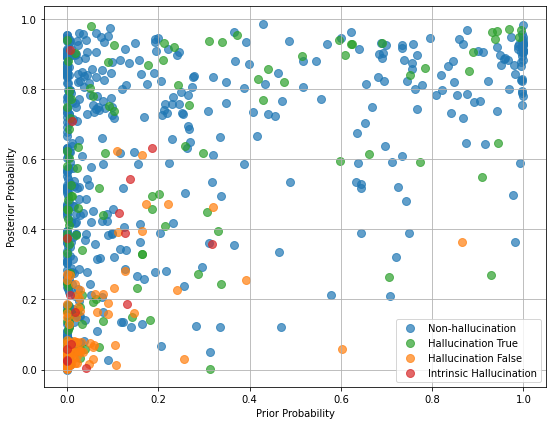

In [108]:
input_data = [
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 0],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 1],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 2],
    [(p['prior'], p['posterior']) for p in prior_posterior if p['label'] == 3]
]

input_data_log_scale = [[], [], [], []]
for i in range(len(input_data)):
    for p in input_data[i]:
#         prior, posterior = max(p[0], 1e-6), max(p[1], 1e-6)
#         input_data_log_scale[i].append((-math.log(prior), -math.log(posterior)))
        input_data_log_scale[i].append((p[0], p[1]))
        
labels = ['Non-hallucination', 'Hallucination True', 'Hallucination False', 'Intrinsic Hallucination']
plot_scatter(input_data_log_scale, labels)

#### Compare CMLM

In [109]:
import matplotlib.pyplot as plt

import matplotlib
matplotlib.rcParams['text.usetex'] = False

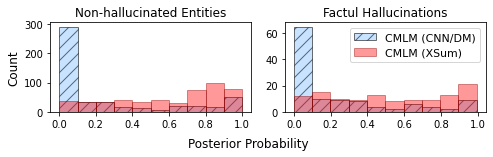

In [110]:
n_bins = 10
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2, figsize=(7.0, 2.0))

my_blue = (153/255, 204/255, 1.0, 0.55)
my_edge = (0., 0., 0., 0.55)

priors_0 = [p['prior'] for p in prior_posterior if p['label'] == 0]
posteriors_0 = [p['posterior'] for p in prior_posterior if p['label'] == 0]
_, bins, _ = ax0.hist(priors_0, n_bins, density=False, histtype='bar', label='CMLM trained on CNN/DM',
                      facecolor=my_blue, edgecolor=my_edge, hatch='//')
ax0.hist(posteriors_0, bins=bins, density=False, histtype='bar',
         facecolor='red', label='CMLM trained on XSum', edgecolor='darkred', alpha=0.40)
ax0.set_ylabel('Count', fontsize=12)
ax0.set_title('Non-hallucinated Entities', fontsize=12)

priors_1 = [p['prior'] for p in prior_posterior if p['label'] == 1]
posteriors_1 = [p['posterior'] for p in prior_posterior if p['label'] == 1]
_, bins, _ = ax1.hist(priors_1, n_bins, density=False, histtype='bar', 
                      facecolor=my_blue, label='CMLM (CNN/DM)', edgecolor=my_edge, hatch='//')
ax1.hist(posteriors_1, bins=bins, density=False, histtype='bar',
         facecolor='red', label='CMLM (XSum)', edgecolor='darkred', alpha=0.40)
ax1.legend(prop={'size': 11})
ax1.set_title('Factul Hallucinations', fontsize=12)

fig.text(0.5, -0.05, 'Posterior Probability', ha='center', fontsize=12)
# fig.text(0.0, 0.5, 'Count', va='center', rotation='vertical', fontsize=12)
fig.tight_layout()

plt.savefig("figures/" + 'hist_2cmlm' +'.pdf', bbox_inches="tight")
plt.show()

In [111]:
# selected_entities = []
# for e in prior_posterior:
#     if e['label'] == 1:
#         if e['prior'] > 1e-5 and math.log(e['posterior'] / e['prior']) > 5:
#             selected_entities.append(e)
#         if e['prior'] > 0. and math.log(e['posterior'] / e['prior']) < 0:
#             selected_entities.append(e)
#         elif e['posterior'] - e['prior'] > 0.5:
#             selected_entities.append(e)

In [112]:
# print(len(selected_entities))
# print(selected_entities[0])

In [113]:
# json.dump(selected_entities, open('sigma_entities.json', 'w'))

#### Get Average Entropy

In [114]:
import math

from draw import plot_hist

In [115]:
for l in range(3):
    posteriors = [p['prior'] for p in prior_posterior if p['label'] == l]
    print('- label {}: {}'.format(l, -math.log(sum(posteriors) / len(posteriors))))

- label 0: 1.404350662654027
- label 1: 1.4591605446529026
- label 2: 2.790782965517991


In [116]:
threshold = 0.0001
posteriors = [[], [], []]
for l in range(3):
    for p in prior_posterior:
        if p['label'] == l and p['posterior'] > threshold:
            posteriors[l].append(p['posterior'])

In [117]:
threshold = 1e-7
priors= [[], [], []]
for l in range(3):
    for p in prior_posterior:
        if p['label'] == l and p['prior'] > threshold:
            priors[l].append(p['prior'])

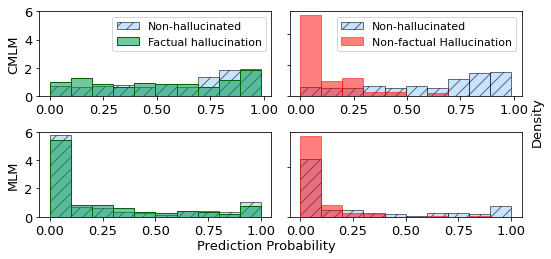

In [118]:
plot_hist('histogram', posteriors, priors, save_fig=True)

#### Evaluate Baseline Models

In [119]:
from sklearn.metrics import classification_report, f1_score, balanced_accuracy_score, accuracy_score

In [120]:
prior_posterior[0]

{'start': 2,
 'end': 7,
 'label': 0,
 'type': 'ORG',
 'ent': 'Wigan',
 'bart.large': 1.1265277862548828e-05,
 'xsum_cmlm_bos': 0.019073486328125,
 'bart.large.xsum': 0.0927734375,
 'cnndm_cmlm_cedar': 0.80859375,
 'cnndm_cmlm_scratch_cedar_warmup_10000': 0.00147247314453125,
 'xsum_cmlm_scratch_cedar_warmup_20000': 0.01239013671875,
 'id': 8805,
 'prior': 1.1265277862548828e-05,
 'posterior': 0.0927734375}

In [121]:
true_label, factual_label, hallucination_label = [], [], []
prior_probabilities, posterior_probabilities = [], []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        if p['label'] == 0 or p['label'] == 1:
            factual_label.append(1)
        elif p['label'] == 2:
            factual_label.append(0)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        if p['label'] == 0:
            hallucination_label.append(0)
        elif p['label'] == 2 or p['label'] == 1:
            hallucination_label.append(1)
        else:
            raise Exception("ERROR! {}".format(p['label']))
            
        true_label.append(p['label'])
        prior_probabilities.append(p['prior'])
        posterior_probabilities.append(p['posterior'])

In [122]:
lm_baseline_preds = []
overlap_preds = []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        source = xsum_source[p['id']]

        if p['ent'].lower() in source.lower():
            overlap_preds.append(1)
        else:
            overlap_preds.append(0)

        if p['posterior'] > p['prior']:
            lm_baseline_preds.append(1)
        else:
            lm_baseline_preds.append(0)

In [123]:
print(balanced_accuracy_score(factual_label, overlap_preds))
print(classification_report(factual_label, overlap_preds, target_names=['Non-factual', 'Factual'], digits=4))

0.8425057270644704
              precision    recall  f1-score   support

 Non-factual     0.3517    0.9326    0.5108        89
     Factual     0.9873    0.7524    0.8540       618

    accuracy                         0.7751       707
   macro avg     0.6695    0.8425    0.6824       707
weighted avg     0.9073    0.7751    0.8108       707



In [124]:
print(balanced_accuracy_score([1 if i == 0 else 0 for i in hallucination_label], overlap_preds))
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], overlap_preds, 
                            target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

0.9378853861569292
                  precision    recall  f1-score   support

Non-hallucinated     0.8390    0.9519    0.8919       208
    Hallucinated     0.9788    0.9238    0.9505       499

        accuracy                         0.9321       707
       macro avg     0.9089    0.9379    0.9212       707
    weighted avg     0.9376    0.9321    0.9333       707



In [125]:
print(classification_report(factual_label, lm_baseline_preds, target_names=['Non-factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-factual     0.0909    0.1124    0.1005        89
     Factual     0.8677    0.8382    0.8527       618

    accuracy                         0.7468       707
   macro avg     0.4793    0.4753    0.4766       707
weighted avg     0.7699    0.7468    0.7580       707



In [126]:
print(classification_report([1 if i == 0 else 0 for i in hallucination_label], lm_baseline_preds, 
                            target_names=['Non-hallucinated', 'Hallucinated'], digits=4))

                  precision    recall  f1-score   support

Non-hallucinated     0.2273    0.1202    0.1572       208
    Hallucinated     0.6935    0.8297    0.7555       499

        accuracy                         0.6209       707
       macro avg     0.4604    0.4749    0.4564       707
    weighted avg     0.5563    0.6209    0.5795       707



### KNN Evaluation

In [127]:
import numpy as np
import matplotlib

from sklearn import neighbors
from draw import plot, plot_three, plot_three_with_boundary

In [128]:
def leave_one_out_error(prior_probs, posterior_probs, labels, n_neighbors=15):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j]])
                train_labels.append(labels[j])
    
        classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

        x_mat = np.array(train_features)
        y_vec = np.array(train_labels)
        classifier.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i]]])
        Z = classifier.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [129]:
n = 15
hallucination_label_reverse = [1 if i == 0 else 0 for i in hallucination_label]
knn_preds = leave_one_out_error(prior_probabilities, posterior_probabilities, hallucination_label_reverse, n_neighbors=n)
print(balanced_accuracy_score(hallucination_label_reverse, knn_preds))
print(classification_report(hallucination_label_reverse, knn_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

0.6307904270078619
                  precision    recall  f1-score   support

    Hallucinated     0.6116    0.3558    0.4498       208
Non-hallucinated     0.7713    0.9058    0.8332       499

        accuracy                         0.7440       707
       macro avg     0.6915    0.6308    0.6415       707
    weighted avg     0.7243    0.7440    0.7204       707



In [130]:
knn_preds = leave_one_out_error(overlap_preds, posterior_probabilities, factual_label, n_neighbors=16)
print(balanced_accuracy_score(factual_label, knn_preds))
print(classification_report(factual_label, knn_preds, target_names=['Non-Factual', 'Factual'], digits=4))

0.8264244936547762
              precision    recall  f1-score   support

 Non-Factual     0.6495    0.7079    0.6774        89
     Factual     0.9574    0.9450    0.9511       618

    accuracy                         0.9151       707
   macro avg     0.8034    0.8264    0.8143       707
weighted avg     0.9186    0.9151    0.9167       707



In [131]:
knn_preds = leave_one_out_error(prior_probabilities, posterior_probabilities, true_label, n_neighbors=20)
print(balanced_accuracy_score(true_label, knn_preds))
print(classification_report(true_label, knn_preds, target_names=['Non-hallucinated', 'Factual', 'Non-factual'], digits=4))

0.4950725420879212
                  precision    recall  f1-score   support

Non-hallucinated     0.7613    0.9459    0.8436       499
         Factual     0.0000    0.0000    0.0000       119
     Non-factual     0.5581    0.5393    0.5486        89

        accuracy                         0.7355       707
       macro avg     0.4398    0.4951    0.4641       707
    weighted avg     0.6076    0.7355    0.6645       707



#### KNN with Three Features

In [132]:
import random

In [133]:
random.uniform(0.00, 0.01)

0.006082542438853436

In [134]:
def leave_one_out_error_three_features(prior_probs, posterior_probs, overlaps, labels, n_neighbors=15):
    assert len(prior_probs) == len(posterior_probs) == len(labels) == len(overlaps)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j], overlaps[j]])
                train_labels.append(labels[j])
    
        classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')
        
#         x_mat = np.array(train_features)
#         y_vec = np.array(train_labels)
#         classifier.fit(x_mat, y_vec)

#         test_features = np.array([[prior_probs[i], posterior_probs[i], overlaps[i]]])
        
        x_mat = np.array(train_features)
        stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1]), np.std(x_mat[:, 2])]
        x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1], x_mat[:, 2]/stds[2]]).transpose()
        y_vec = np.array(train_labels)
        classifier.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i] / stds[0],
                                   posterior_probs[i] / stds[1],
                                   overlaps[i]] / stds[2]])
        
        Z = classifier.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [135]:
hal_preds = leave_one_out_error_three_features(prior_probabilities, posterior_probabilities, overlap_preds, hallucination_label_reverse, n_neighbors=15)
print(balanced_accuracy_score(hallucination_label_reverse, hal_preds))
print(classification_report(hallucination_label_reverse, hal_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

0.9138469246184677
                  precision    recall  f1-score   support

    Hallucinated     0.8319    0.9038    0.8664       208
Non-hallucinated     0.9584    0.9238    0.9408       499

        accuracy                         0.9180       707
       macro avg     0.8951    0.9138    0.9036       707
    weighted avg     0.9212    0.9180    0.9189       707



In [136]:
fact_preds = leave_one_out_error_three_features(prior_probabilities, posterior_probabilities, overlap_preds, factual_label, n_neighbors=30)
print(balanced_accuracy_score(factual_label, fact_preds))
print(classification_report(factual_label, fact_preds, target_names=['Non-Factual', 'Factual'], digits=4))

0.6435947783716955
              precision    recall  f1-score   support

 Non-Factual     0.7297    0.3034    0.4286        89
     Factual     0.9075    0.9838    0.9441       618

    accuracy                         0.8982       707
   macro avg     0.8186    0.6436    0.6863       707
weighted avg     0.8851    0.8982    0.8792       707



In [137]:
merged_preds = []
for h, f in zip(hal_preds, fact_preds):
    if h == 0 and f == 0:
        merged_preds.append(2)
    elif h == 1 and f == 1:
        merged_preds.append(0)
    elif h == 0 and f == 1:
        merged_preds.append(1)
    elif h == 1 and f == 0:
        print('error')
    else:
        raise Exception("unexpected value!!!")

print(balanced_accuracy_score(true_label, merged_preds))
print(classification_report(true_label, merged_preds, target_names=['Non-hallucinated', 'Factual hal.', 'Non-factual hal.'], digits=4))

0.6891848721204723
                  precision    recall  f1-score   support

Non-hallucinated     0.9584    0.9238    0.9408       499
    Factual hal.     0.5291    0.8403    0.6494       119
Non-factual hal.     0.7297    0.3034    0.4286        89

        accuracy                         0.8317       707
       macro avg     0.7391    0.6892    0.6729       707
    weighted avg     0.8574    0.8317    0.8273       707



In [138]:
knn_preds = leave_one_out_error_three_features(prior_probabilities, posterior_probabilities, overlap_preds, true_label, n_neighbors=15)
print(balanced_accuracy_score(true_label, knn_preds))
print(classification_report(true_label, knn_preds, target_names=['Non-hallucinated', 'Factual hal.', 'Non-factual hal.'], digits=4))

0.6956651476875004
                  precision    recall  f1-score   support

Non-hallucinated     0.9432    0.9319    0.9375       499
    Factual hal.     0.5576    0.7731    0.6479       119
Non-factual hal.     0.6939    0.3820    0.4928        89

        accuracy                         0.8359       707
       macro avg     0.7316    0.6957    0.6927       707
    weighted avg     0.8469    0.8359    0.8328       707



#### KNN on Test Set

In [139]:
import random

In [140]:
random.seed(0)

In [141]:
prior_probabilities, posterior_probabilities, overlap_preds
assert len(prior_probabilities) == len(posterior_probabilities)
assert len(overlap_preds) == len(factual_label)

train_features, train_labels, train_true_labels = [], [], []
test_features, test_labels, test_true_labels = [], [], []

for i in range(len(prior_probabilities)):
    if random.random() >= 0.3:
        train_features.append([prior_probabilities[i], posterior_probabilities[i], overlap_preds[i]])
        train_labels.append(factual_label[i])
        train_true_labels.append(true_label[i])
    else:
        test_features.append([prior_probabilities[i], posterior_probabilities[i], overlap_preds[i]])
        test_labels.append(factual_label[i])
        test_true_labels.append(true_label[i])
        
print(len(train_features))
print(len(test_features))
classifier = neighbors.KNeighborsClassifier(n_neighbors=17, algorithm='auto')

500
207


In [142]:
# fit (three features)
x_mat = np.array(train_features)
stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1]), np.std(x_mat[:, 2])]
x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1], x_mat[:, 2]/stds[2]]).transpose()
y_vec = np.array(train_labels)
classifier.fit(x_mat, y_vec)

KNeighborsClassifier(n_neighbors=17)

In [143]:
# predict (three features)
x_mat = np.array(test_features)
stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1]), np.std(x_mat[:, 2])]
x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1], x_mat[:, 2]/stds[2]]).transpose()
Z = classifier.predict(x_mat)

In [144]:
print(balanced_accuracy_score(test_labels, Z))
print(classification_report(test_labels, Z, target_names=['Non-Factual', 'Factual'], digits=4))

0.8206521739130435
              precision    recall  f1-score   support

 Non-Factual     0.4857    0.7391    0.5862        23
     Factual     0.9651    0.9022    0.9326       184

    accuracy                         0.8841       207
   macro avg     0.7254    0.8207    0.7594       207
weighted avg     0.9118    0.8841    0.8941       207



In [145]:
pickle.dump(classifier, open('classifiers/knn_classifier_trained.pkl', 'wb'))

In [188]:
# fit (three features, three labels)
x_mat = np.array(train_features)
stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1]), np.std(x_mat[:, 2])]
x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1], x_mat[:, 2]/stds[2]]).transpose()
y_vec = np.array(train_true_labels)
classifier.fit(x_mat, y_vec)

KNeighborsClassifier(n_neighbors=17)

In [189]:
# predict (three features, three labels)
x_mat = np.array(test_features)
stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1]), np.std(x_mat[:, 2])]
x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1], x_mat[:, 2]/stds[2]]).transpose()
Z = classifier.predict(x_mat)

In [190]:
print(balanced_accuracy_score(test_true_labels, Z))
print(classification_report(test_true_labels, Z, target_names=['Non-hallucinated', 'Factual hal.', 'Non-factual hal.'], digits=4))

0.7927882212739784
                  precision    recall  f1-score   support

Non-hallucinated     0.9924    0.9034    0.9458       145
    Factual hal.     0.7105    0.6923    0.7013        39
Non-factual hal.     0.4865    0.7826    0.6000        23

        accuracy                         0.8502       207
       macro avg     0.7298    0.7928    0.7490       207
    weighted avg     0.8831    0.8502    0.8613       207



In [191]:
# fit (two features)
train_features_two = [[f[0], f[1]] for f in train_features]
test_features_two = [[f[0], f[1]] for f in test_features]
x_mat = np.array(train_features_two)
stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1])]
x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1]]).transpose()
y_vec = np.array(train_labels)
classifier.fit(x_mat, y_vec)

KNeighborsClassifier(n_neighbors=17)

In [192]:
# predict (two features)
x_mat = np.array(test_features_two)
stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1])]
x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1]]).transpose()
Z = classifier.predict(x_mat)

In [193]:
print(balanced_accuracy_score(test_labels, Z))
print(classification_report(test_labels, Z, target_names=['Non-Factual', 'Factual'], digits=4))

0.7092391304347826
              precision    recall  f1-score   support

 Non-Factual     0.5000    0.4783    0.4889        23
     Factual     0.9351    0.9402    0.9377       184

    accuracy                         0.8889       207
   macro avg     0.7176    0.7092    0.7133       207
weighted avg     0.8868    0.8889    0.8878       207



In [194]:
Z

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1])

In [152]:
# LM baseline
lm_baseline = []
for f in test_features:
    if f[1] > f[0]:
        lm_baseline.append(1)
    else:
        lm_baseline.append(0)
print(balanced_accuracy_score(test_labels, lm_baseline))
print(classification_report(test_labels, lm_baseline, target_names=['Non-Factual', 'Factual'], digits=4))

0.48097826086956524
              precision    recall  f1-score   support

 Non-Factual     0.0882    0.1304    0.1053        23
     Factual     0.8844    0.8315    0.8571       184

    accuracy                         0.7536       207
   macro avg     0.4863    0.4810    0.4812       207
weighted avg     0.7959    0.7536    0.7736       207



In [153]:
# overlap
print(balanced_accuracy_score(test_labels, [i[2] for i in test_features]))
print(classification_report(test_labels, [i[2] for i in test_features], target_names=['Non-Factual', 'Factual'], digits=4))

0.8342391304347827
              precision    recall  f1-score   support

 Non-Factual     0.2933    0.9565    0.4490        23
     Factual     0.9924    0.7120    0.8291       184

    accuracy                         0.7391       207
   macro avg     0.6429    0.8342    0.6390       207
weighted avg     0.9147    0.7391    0.7869       207



#### 10 Cross-Validation

In [154]:
from sklearn.model_selection import KFold

In [155]:
all_features, all_labels, all_true_labels = [], [], []

for i in range(len(prior_probabilities)):
        all_features.append([prior_probabilities[i], posterior_probabilities[i], overlap_preds[i]])
        all_labels.append(factual_label[i])
        all_true_labels.append(true_label[i])

all_features = np.array(all_features)
all_labels = np.array(all_labels)
all_true_labels = np.array(all_true_labels)
print(all_features.shape)
print(all_labels.shape)

(707, 3)
(707,)


In [156]:
kf = KFold(n_splits=30, shuffle=True, random_state=1024)
kf.get_n_splits(all_features)

30

In [157]:
def train(train_features, train_labels):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=17, algorithm='auto')
    
    x_mat = np.array(train_features)
    stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1]), np.std(x_mat[:, 2])]
    x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1], x_mat[:, 2]/stds[2]]).transpose()
    y_vec = np.array(train_labels)
    classifier.fit(x_mat, y_vec)

#     x_mat = np.array(train_features)
#     stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1])]
#     x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1]]).transpose()
#     y_vec = np.array(train_labels)
#     classifier.fit(x_mat, y_vec)
    
    return classifier

In [158]:
def predict(test_features, classifier):
    x_mat = np.array(test_features)
    stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1]), np.std(x_mat[:, 2])]
    x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1], x_mat[:, 2]/stds[2]]).transpose()

#     stds = [np.std(x_mat[:, 0]), np.std(x_mat[:, 1])]
#     x_mat = np.vstack([x_mat[:, 0]/stds[0],  x_mat[:, 1]/stds[1]]).transpose()
    
    return classifier.predict(x_mat)

In [159]:
accs = []
for train_index, test_index in kf.split(all_features):
    classifier = train(all_features[train_index], all_labels[train_index])
    Z = predict(all_features[test_index], classifier)
    accs.append(accuracy_score(all_labels[test_index], Z))

In [160]:
accs

[0.9166666666666666,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.9583333333333334,
 0.8333333333333334,
 0.9166666666666666,
 1.0,
 0.9166666666666666,
 0.875,
 0.9583333333333334,
 0.875,
 0.875,
 0.75,
 0.9166666666666666,
 1.0,
 0.9583333333333334,
 0.9130434782608695,
 0.8260869565217391,
 0.8695652173913043,
 0.9130434782608695,
 0.9565217391304348,
 0.9565217391304348,
 0.9130434782608695,
 0.9565217391304348,
 0.9565217391304348,
 0.9565217391304348,
 0.9130434782608695,
 0.8260869565217391,
 0.8695652173913043]

#### SVM with RBF Kernel

In [161]:
import numpy as np
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier

In [162]:
def leave_one_out_error_svm(prior_probs, posterior_probs, labels, linear=False):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j]])
                train_labels.append(labels[j])
        
        x_mat = np.array(train_features)
        y_vec = np.array(train_labels)
        
        if linear:
            clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
        else:
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        clf.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i]]])
        Z = clf.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [163]:
def leave_one_out_error_svm_three_features(prior_probs, posterior_probs, overlaps, labels, linear=False):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    preds = []
    for i in range(len(prior_probs)):
        train_features, train_labels = [], []
        for j in range(len(prior_probs)):
            if j != i:
                train_features.append([prior_probs[j], posterior_probs[j], overlaps[j]])
                train_labels.append(labels[j])
        
        x_mat = np.array(train_features)
        y_vec = np.array(train_labels)
        
        if linear:
            clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
        else:
            clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
        clf.fit(x_mat, y_vec)
        
        test_features = np.array([[prior_probs[i], posterior_probs[i], overlaps[i]]])
        Z = clf.predict(test_features)
        preds.append(Z[0])
    
    return preds

In [164]:
def save_svm(posterior_probs, prior_probs, overlaps, labels, linear=False):
    assert len(prior_probs) == len(posterior_probs) == len(labels)
    
    x_mat = np.array([posterior_probs, prior_probs, overlaps]).transpose()
    y_vec = np.array(labels)

    if linear:
        clf = make_pipeline(StandardScaler(), SGDClassifier(max_iter=1000, tol=1e-3))
    else:
        clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
    clf.fit(x_mat, y_vec)

    return clf

In [165]:
svm_preds = leave_one_out_error_svm(prior_probabilities, posterior_probabilities, factual_label)
print(classification_report(factual_label, svm_preds, target_names=['Factual', 'Non-factual'], digits=4))

              precision    recall  f1-score   support

     Factual     0.0000    0.0000    0.0000        89
 Non-factual     0.8741    1.0000    0.9328       618

    accuracy                         0.8741       707
   macro avg     0.4371    0.5000    0.4664       707
weighted avg     0.7641    0.8741    0.8154       707



/home/mcao610/env37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mcao610/env37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mcao610/env37/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [166]:
svm_preds = leave_one_out_error_svm(prior_probabilities, posterior_probabilities, hallucination_label_reverse)
print(classification_report(hallucination_label_reverse, svm_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

                  precision    recall  f1-score   support

    Hallucinated     0.5923    0.3702    0.4556       208
Non-hallucinated     0.7730    0.8938    0.8290       499

        accuracy                         0.7397       707
       macro avg     0.6826    0.6320    0.6423       707
    weighted avg     0.7198    0.7397    0.7191       707



In [167]:
svm_preds = leave_one_out_error_svm_three_features(prior_probabilities, posterior_probabilities, overlap_preds, hallucination_label_reverse)
print(classification_report(hallucination_label_reverse, svm_preds, target_names=['Factual', 'Non-factual'], digits=4))

              precision    recall  f1-score   support

     Factual     0.8390    0.9519    0.8919       208
 Non-factual     0.9788    0.9238    0.9505       499

    accuracy                         0.9321       707
   macro avg     0.9089    0.9379    0.9212       707
weighted avg     0.9376    0.9321    0.9333       707



In [168]:
svm_classifier = save_svm(posterior_probabilities, prior_probabilities, overlap_preds, factual_label)

In [169]:
# pickle.dump(svm_classifier, open('classifiers/svm_classifier.pkl', 'wb'))

#### Linear Model

In [170]:
linear_preds = leave_one_out_error_svm(prior_probabilities, posterior_probabilities, factual_label, linear=True)
print(classification_report(factual_label, linear_preds, target_names=['Factual', 'Non-factual'], digits=4))

              precision    recall  f1-score   support

     Factual     0.4098    0.2809    0.3333        89
 Non-factual     0.9009    0.9417    0.9209       618

    accuracy                         0.8586       707
   macro avg     0.6554    0.6113    0.6271       707
weighted avg     0.8391    0.8586    0.8469       707



In [171]:
linear_preds = leave_one_out_error_svm(prior_probabilities, posterior_probabilities, hallucination_label_reverse, linear=True)
print(classification_report(hallucination_label_reverse, linear_preds, target_names=['Hallucinated', 'Non-hallucinated'], digits=4))

                  precision    recall  f1-score   support

    Hallucinated     0.4559    0.2981    0.3605       208
Non-hallucinated     0.7443    0.8517    0.7944       499

        accuracy                         0.6888       707
       macro avg     0.6001    0.5749    0.5774       707
    weighted avg     0.6595    0.6888    0.6667       707



In [172]:
linear_preds = leave_one_out_error_svm_three_features(prior_probabilities, posterior_probabilities, overlap_preds, hallucination_label_reverse, linear=True)
print(classification_report(hallucination_label_reverse, linear_preds, target_names=['Factual', 'Non-factual'], digits=4))

              precision    recall  f1-score   support

     Factual     0.8326    0.9327    0.8798       208
 Non-factual     0.9705    0.9218    0.9455       499

    accuracy                         0.9250       707
   macro avg     0.9015    0.9273    0.9127       707
weighted avg     0.9299    0.9250    0.9262       707



#### KNN Classification Boundaries

In [173]:
font = {'weight' : 'normal',
        'size'   : 8}

matplotlib.rc('font', **font)

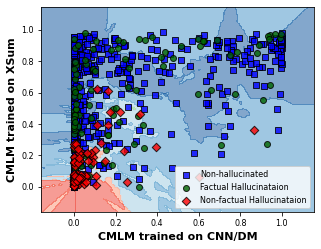

In [174]:
plot_three_with_boundary('entity_distribution_2cmlm',
                         posterior_probabilities, prior_probabilities, true_label,
                         colors=['blue', 'darkgreen', 'red'],
                         legend_labels=['Non-hallucinated', 'Factual Hallucinataion', 'Non-factual Hallucinataion'],
                         x_label='CMLM trained on CNN/DM',
                         y_label='CMLM trained on XSum',
                         n_neighbors=16,
                         fig_size=(4.5, 3.5),
                         interval=0.25, h=0.05,
                         save_figure=True)

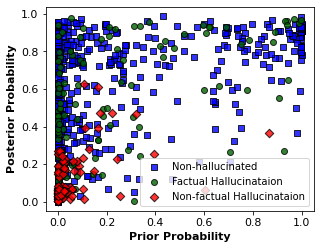

In [175]:
plot_three('entity_distribution_mlm_cmlm',
           posterior_probabilities, prior_probabilities, true_label,
           colors=['blue','darkgreen', 'red'],
           x_label='Prior Probability',
           y_label='Posterior Probability',
           legend_labels=['Non-hallucinated', 'Factual Hallucinataion', 'Non-factual Hallucinataion'],
           n_neighbors=10,
           fig_size=(4.5, 3.5),
           save_figure=True)

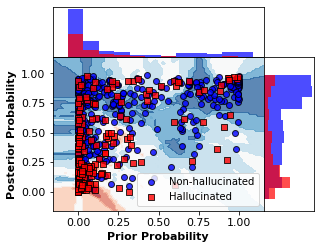

In [176]:
plot('hallucination_class',
     posterior_probabilities, prior_probabilities, [1 if i == 0 else 0 for i in hallucination_label], 
     n_neighbors=12, fig_size=(4.5, 3.5), colors=['red', 'blue'], legend_labels=['Hallucinated', 'Non-hallucinated'], save_figure=True)

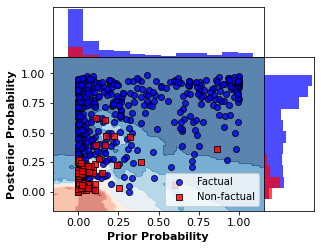

In [177]:
plot('factuality_class', posterior_probabilities, prior_probabilities, factual_label, n_neighbors=20, 
     fig_size=(4.5, 3.5), colors=['red', 'blue'], legend_labels=['Non-factual', 'Factual'],
     x_label='Prior Probability', y_label='Posterior Probability', save_figure=True)

#### Save KNN Model

In [178]:
import pickle

In [179]:
def build_KNN(posteriors, priors, labels, overlaps=None, n_neighbors=15):
    classifier = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors, algorithm='auto')

    priors = np.array(priors)
    posteriors = np.array(posteriors)
    
#     x_mat = np.vstack([posteriors / np.std(posteriors), priors / np.std(priors)]).transpose()
    if overlaps is not None:
        overlaps = np.array(overlaps)
        x_mat = np.vstack([posteriors, priors, overlaps]).transpose()
    else:
        x_mat = np.vstack([posteriors, priors]).transpose()
    y_vec = np.array(labels)
    
    classifier.fit(x_mat, y_vec)
    
    return classifier

In [180]:
knn_classifier = build_KNN(posterior_probabilities, prior_probabilities, factual_label, overlaps=overlap_preds, n_neighbors=15)

In [181]:
preds = knn_classifier.predict(np.array(np.vstack([posterior_probabilities, prior_probabilities, overlap_preds]).transpose()))

In [182]:
print(classification_report(factual_label, preds, target_names=['Non-Factual', 'Factual'], digits=4))

              precision    recall  f1-score   support

 Non-Factual     0.7125    0.6404    0.6746        89
     Factual     0.9490    0.9628    0.9558       618

    accuracy                         0.9222       707
   macro avg     0.8307    0.8016    0.8152       707
weighted avg     0.9192    0.9222    0.9204       707



In [183]:
pickle.dump(knn_classifier, open('classifiers/knn_mlm_cmlm_3.pkl', 'wb'))

#### AUC

In [184]:
from draw import draw_auc

In [185]:
p1, p2, p3, p4, p5, p6, p7 = [], [], [], [], [], [], []

for p in prior_posterior:
    if p['label'] is not None and p['label'] != 3:
        p1.append(p['bart.large'])
        p2.append(p['xsum_cmlm_bos'])
        p3.append(p['xsum_cmlm_scratch_cedar_warmup_20000'])
        p4.append(p['cnndm_cmlm_cedar'])
        p5.append(p['cnndm_cmlm_scratch_cedar_warmup_10000'])
        p6.append(p['bart.large.xsum'])
#         p7.append(p['bart.large.cnn'])

assert len(p1) == len(factual_label)

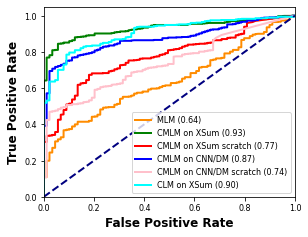

In [186]:
draw_auc(factual_label,
         [p1, p2, p3, p4, p5, p6],
         ['MLM', 'CMLM on XSum', 'CMLM on XSum scratch', 'CMLM on CNN/DM', 'CMLM on CNN/DM scratch', 'CLM on XSum'],
         ['darkorange', 'green', 'red', 'blue', 'pink', 'aqua'])

In [187]:
# draw_auc(factual_label,
#          [p2, p6, p4, p7],
#          ['CMLM on XSum', 'CLM on XSum', 'CMLM on CNN/DM', 'CLM on CNN/DM'],
#          ['darkorange', 'green', 'red', 'blue'])